In [1]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import pandas as pd
train = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/test.csv')
train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


- 데이터는 id, keyword, location, text, target 등 총 5개 변수로 이루어져 있습니다.
- id - 각 트위터 데이터의 식별자
- keyword - 해당 트윗의 특정 키워드
- location - 트위터가 작성된 장소
- text - 실제 트윗의 메시지
- target - 트위터가 실제로 재난이라면 1, 가짜라면 0으로 표시

In [3]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


- test 데이터에 target 변수 명이 없는 것을 확인할 수 있음

## 탐색적 자료 분석

<ipython-input-4-68b5ad668110>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


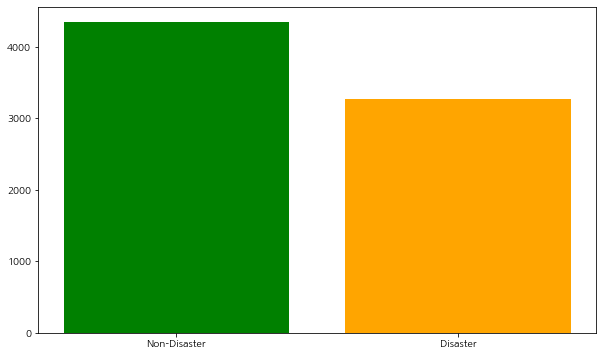

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns
news_class = train['target'].value_counts()
labels = ['Non-Disaster', 'Disaster']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, news_class, color=['green', 'orange'])

fig.show()

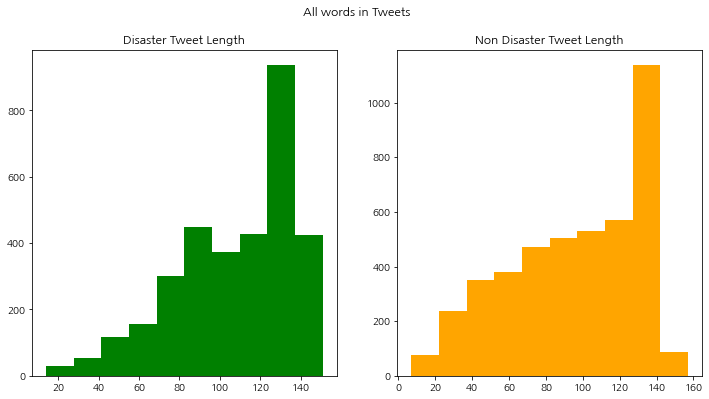

In [5]:
# 트윗 데이터 시각화
disaster_tweet_len = train[train['target']==1]['text'].str.len()
non_disaster_tweet_len = train[train['target']==0]['text'].str.len()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(disaster_tweet_len, color='green')
ax[0].set_title('Disaster Tweet Length')

ax[1].hist(non_disaster_tweet_len, color='orange')
ax[1].set_title('Non Disaster Tweet Length')

fig.suptitle('All words in Tweets')
plt.show()

- 길이가 140 이후 Non Disaster는 급격하게 떨어지는 것을 확인

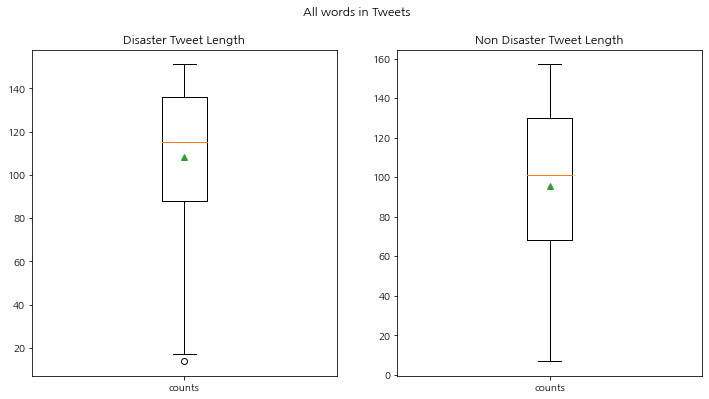

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].boxplot(disaster_tweet_len, labels=['counts'], showmeans=True)
ax[0].set_title('Disaster Tweet Length')

ax[1].boxplot(non_disaster_tweet_len, labels=['counts'], showmeans=True)
ax[1].set_title('Non Disaster Tweet Length')

fig.suptitle('All words in Tweets')
plt.show()


- 두 데이터 모두 중간값보다 작은 값을 나타내는 것을 확인할 수 있음

In [7]:
## Numpy 활용
import numpy as np

disaster_tweet_len = train[train['target']==1]['text'].str.len()
non_disaster_tweet_len = train[train['target']==0]['text'].str.len()

print('Max Length of Disaster Tweet: {}'.format(np.max(disaster_tweet_len)))
print('Min Length of Disaster Tweet: {}'.format(np.min(disaster_tweet_len)))
print('Mean Length of Disaster Tweet: {}'.format(np.mean(disaster_tweet_len)))
print('Median Length of Disaster Tweet: {}'.format(np.median(disaster_tweet_len)))

print('Max Length of Non Disaster Tweet: {}'.format(np.max(non_disaster_tweet_len)))
print('Min Length of Non Disaster Tweet: {}'.format(np.min(non_disaster_tweet_len)))
print('Mean Length of Non Disaster Tweet: {}'.format(np.mean(non_disaster_tweet_len)))
print('Median Length of Non Disaster Tweet: {}'.format(np.median(non_disaster_tweet_len)))

Max Length of Disaster Tweet: 151
Min Length of Disaster Tweet: 14
Mean Length of Disaster Tweet: 108.11342097217977
Median Length of Disaster Tweet: 115.0
Max Length of Non Disaster Tweet: 157
Min Length of Non Disaster Tweet: 7
Mean Length of Non Disaster Tweet: 95.70681713496084
Median Length of Non Disaster Tweet: 101.0


<ipython-input-8-cdc058eae20e>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


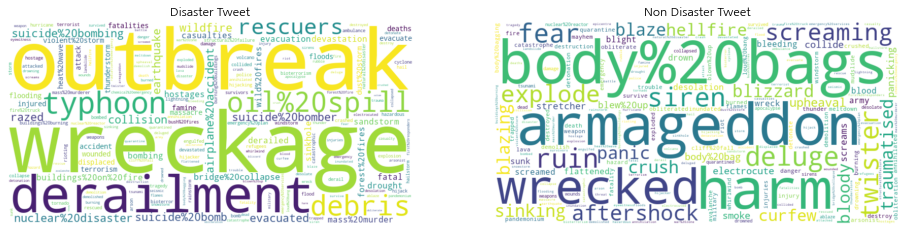

In [8]:
## wordcloud 활용
from wordcloud import WordCloud, STOPWORDS

disaster_tweet_keywords = dict(train[train['target']==1]['keyword'].value_counts())
non_disaster_tweet_keywords = dict(train[train['target']==0]['keyword'].value_counts())

stopwords=set(STOPWORDS)
disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').\
    generate_from_frequencies(disaster_tweet_keywords)

non_disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').\
    generate_from_frequencies(non_disaster_tweet_keywords)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweet')

ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non Disaster Tweet')

fig.show()

- Disaster 트윗은 Derailment(탈선), Outbreak(어떤 사건의 발생), Wreckage(난파), Typhoon(태풍) 등
     명사 하나로도 충분하게 설명되는 진짜 재난 뉴스인 반면
- Non Disaster 트윗은 명사보단 형용사나 동사가 주로 사용되는 것을 확인할 수 있음

## 피처 엔지니어링

In [9]:
# 결측치 확인
import pandas as pd
def check_na(data):
    isnull_na = (data.isnull().sum()/len(data))*100
    data_na = isnull_na.drop(isnull_na[isnull_na==0].index).sort_values(ascending=False)
    missing_data=pd.DataFrame({'Missing Ratio': data_na,
                                'Data Type': data.dtypes[data_na.index]})
    print('결측치 데이터 칼럼과 건수:\n', missing_data)

check_na(train)
check_na(test)

결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.272035    object
keyword        0.801261    object
결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.864542    object
keyword        0.796813    object


In [10]:
# test_id만 따로 추출해 저장
test_id = test['id']
for datas in [train, test]:
    datas = datas.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
    
train.shape, test.shape

((7613, 2), (3263, 1))

### Text Cleansing
- HTML 태그 제거
- 특수문자 공백으로 바꾸기
- 대문자 소문자로 바꾼 후, 리스트로 만들기
- 불용어 제거하기


In [11]:
# url 제거
import re


def remove_url(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)


sample_text = "새로운 캐글 대회가 열렸습니다. 주소: https://www.kaggle.com/c/nlp-getting-started"
remove_url(sample_text)


'새로운 캐글 대회가 열렸습니다. 주소: '

In [12]:
# html 제거
def remove_html(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)


sample_text = """<div>
<h1> Real News or Fake News </h1>
<p> Kaggle Machine Learning </p>
</div>"""

print(remove_html(sample_text))



 Real News or Fake News 
 Kaggle Machine Learning 

